# Evaluation Board

In [2]:
%matplotlib inline
import os, sys
import glob, json
import shutil

import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path += [os.path.abspath('.'), os.path.abspath('..')]  # Add path to root
from birl.utilities.data_io import update_path
from birl.utilities.evaluate import compute_ranking
from birl.utilities.visualisation import RadarChart
from bm_ANHIR.generate_regist_pairs import VAL_STATUS_TRAIN, VAL_STATUS_TEST

This notebook serves for computing extended statistics (e.g. metrics inliding ranks) and visualie some more statistics.

In [3]:
PATH_SUBMISSIONS = os.path.join(update_path('bm_ANHIR'), 'submissions')
PATH_TEMP = os.path.abspath(os.path.expanduser('~/Desktop/ANHIR_submissions'))
PATH_DATASET = os.path.join(update_path('bm_ANHIR'), 'dataset_ANHIR')
PATH_TABLE = os.path.join(PATH_DATASET, 'dataset_medium.csv')
PATH_LNDS_PROVIDED = os.path.join(PATH_DATASET, 'landmarks_all')
PATH_LNDS_COMPLATE = os.path.join(PATH_DATASET, 'landmarks_all')
PATH_COMP_BM = os.path.join(PATH_DATASET, 'computer-performances_cmpgrid-71.json')

## Parse and load submissions

All submissions are expected to be as a zip archives in single folder. The archive name is the author name.

In [4]:
# Find all archives and unzip them to the same folder.
archive_paths = sorted(glob.glob(os.path.join(PATH_SUBMISSIONS, '*.zip')))
submission_dirs = []

for path_zip in tqdm.tqdm(archive_paths, desc='unzipping'):
    sub = os.path.join(PATH_TEMP, os.path.splitext(os.path.basename(path_zip))[0])
    os.system('unzip %s -d %s' % (path_zip, sub))
    sub_ins = glob.glob(os.path.join(sub, '*'))
    if len(sub_ins) == 1:  # if the zip subfolder contain only one folder move it up
        [shutil.move(p, sub) for p in glob.glob(os.path.join(sub_ins[0], '*'))]
    submission_dirs.append(sub)

unzipping: 100%|██████████| 12/12 [00:00<00:00, 57.57it/s]


Parse submissions and compute the final metrics. This can be computed just once.

In [ ]:
import bm_ANHIR.evaluate_submission

for path_sub in tqdm.tqdm(submission_dirs, desc='evaluation'):
    path_json = bm_ANHIR.evaluate_submission.main(
        path_experiment=path_sub,
        path_cover=PATH_TABLE,
        path_dataset=PATH_LNDS_PROVIDED,
        path_reference=PATH_LNDS_COMPLATE,
        path_comp_bm=PATH_COMP_BM,
        path_output=path_sub,
        min_landmarks=1., details=True)
    shutil.copy(os.path.join(path_sub, 'metrics.json'),
                os.path.join(PATH_SUBMISSIONS, os.path.basename(path_sub) + '.json'))

Load parsed measures from each submission/experiment.

In [6]:
submission_paths = sorted(glob.glob(os.path.join(PATH_SUBMISSIONS, '*.json')))
submissions = {}
for path_sub in tqdm.tqdm(submission_paths, desc='loading'):
    with open(path_sub, 'r') as fp:
        metrics = json.load(fp)
    submissions[os.path.splitext(os.path.basename(path_sub))[0]] = metrics

print ('Users: %r' % submissions.keys())

loading: 100%|██████████| 12/12 [00:00<00:00, 90.41it/s]

Users: dict_keys(['BmUnwarpJ', 'HistoReg', 'Mohammed', 'RNiftyReg-linear', 'delamoer', 'lMW', 'masi', 'nick.weiss', 'pszma2', 'punithakumar', 'zhaoshuaibit', 'zsyzzsoft'])


In [7]:
# split the particular fields inside the measured items
users = list(submissions.keys())
print ('Fields: %r' % submissions[users[0]].keys())
user_aggreg = {u: submissions[u]['aggregates'] for u in users}
user_computer = {u: submissions[u]['computer'] for u in users}
user_cases = {u: submissions[u]['cases'] for u in users}
print ('required-landmarks: %r' % [submissions[u]['required-landmarks'] for u in users])

Fields: dict_keys(['aggregates', 'cases', 'computer', 'submission-time', 'required-landmarks'])
required-landmarks: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


## Compute ranked measures

Extend the aggregated statistic by Rank measures such as compute ranking over all cases for each selected field and average it

In [8]:
for robust in [True, False]:  # iterate over Robust or all cases
    for field, field_agg in [('rTRE-Median', 'Average-Rank-Median-rTRE'),
                             ('rTRE-Max', 'Average-Rank-Max-rTRE')]:
        user_cases = compute_ranking(user_cases, field)
        field_agg = field_agg + '-Robust' if robust else field_agg
        for user in users:
            # chose inly robyst if it is required
            vals = [user_cases[user][cs][field + '_rank'] for cs in user_cases[user]
                    if (robust and user_cases[user][cs]['Robustness']) or (not robust)]
            user_aggreg[user][field_agg] = np.mean(vals)

Show the raw table with global statiscit (joint training and testing/evalaution).

In [9]:
cols_general = [col for col in pd.DataFrame(user_aggreg).T.columns 
                if not any(n in col for n in [VAL_STATUS_TRAIN, VAL_STATUS_TEST])]
pd.DataFrame(user_aggreg).T.sort_values('Average-Rank-Median-rTRE')[cols_general]

,Average-Average-rTRE,Average-Average-rTRE-Robust,Average-Max-rTRE,Average-Max-rTRE-Robust,Average-Median-rTRE,Average-Median-rTRE-Robust,Average-Norm-Time,Average-Norm-Time-Robust,Average-Rank-Max-rTRE,Average-Rank-Max-rTRE-Robust,...,Average-Robustness,Average-used-landmarks,Median-Average-rTRE,Median-Average-rTRE-Robust,Median-Max-rTRE,Median-Max-rTRE-Robust,Median-Median-rTRE,Median-Median-rTRE-Robust,Median-Norm-Time,Median-Norm-Time-Robust
nick.weiss,0.005192,0.004321,0.026069,0.024423,0.003853,0.002924,0.145392,0.145501,4.216216,4.200000,...,0.997921,1.025250,0.002889,0.002888,0.018566,0.018537,0.001818,0.001817,0.141754,0.141826
HistoReg,0.004111,0.004111,0.023084,0.023084,0.002836,0.002836,1.266156,1.266156,3.615385,3.615385,...,1.000000,1.025198,0.003005,0.003005,0.017629,0.017629,0.001909,0.001909,1.193946,1.193946
lMW,677.421821,0.005950,51791.188389,0.030922,0.005078,0.004087,6.864099,6.844906,5.525988,5.468487,...,0.989605,1.027857,0.003427,0.003402,0.023499,0.023427,0.001982,0.001976,5.804766,5.790514
zhaoshuaibit,0.004716,0.004707,0.022812,0.022798,0.003506,0.003501,6.098517,6.106647,4.417879,4.408333,...,0.997921,1.026104,0.003499,0.003496,0.017152,0.017111,0.002625,0.002601,4.824366,4.825087
masi,0.014397,0.005423,0.043899,0.030387,0.012722,0.003937,7.387142,7.400403,5.920998,4.985294,...,0.992701,1.007034,0.003719,0.003183,0.023518,0.019463,0.002535,0.002110,NaN,7.258509
zsyzzsoft,0.008204,0.007015,0.028967,0.027379,0.006902,0.005700,0.000388,0.000388,4.800416,4.785417,...,0.997921,1.025250,0.003899,0.003899,0.019283,0.019280,0.003025,0.003014,0.000322,0.000322
delamoer,0.006771,0.006566,0.027119,0.026778,0.005393,0.005177,7.127142,7.155800,5.438669,5.399582,...,0.993763,1.025356,0.005171,0.005155,0.021095,0.020996,0.004110,0.004079,7.488842,7.508170
BmUnwarpJ,0.068075,0.050743,0.135359,0.107761,0.066945,0.049563,6.598389,6.608330,7.496881,7.223714,...,0.929314,1.002125,0.009031,0.007749,0.043462,0.038716,0.005499,0.004741,6.038773,6.030344
Mohammed,0.030193,0.022385,0.085886,0.070053,0.025966,0.018675,0.448220,0.452829,8.280665,8.097506,...,0.916840,1.030068,0.010454,0.009970,0.045230,0.042840,0.008023,0.007507,0.440420,0.445521
pszma2,0.032905,0.022026,0.091407,0.069313,0.028615,0.018273,1.488435,1.507023,9.274428,9.077626,...,0.910603,1.031667,0.010342,0.009738,0.044584,0.042100,0.007908,0.007431,1.386864,1.428676


Show separatlyraw table with statistic for tran and tes cases separatly.

In [10]:
from IPython.display import display
for state in [VAL_STATUS_TRAIN, VAL_STATUS_TEST]:
    cols = [col for col in pd.DataFrame(user_aggreg).T.columns if state in col]
    display(pd.DataFrame(user_aggreg).T.sort_values('Average-Rank-Median-rTRE')[cols])

,Average-Average-rTRE_training,Average-Max-rTRE_training,Average-Median-rTRE_training,Average-Robustness_training,Median-Average-rTRE_training,Median-Max-rTRE_training,Median-Median-rTRE_training
nick.weiss,0.006096,0.027120,0.004924,0.995652,0.002964,0.018286,0.001857
HistoReg,0.004016,0.022330,0.002805,1.000000,0.003054,0.017197,0.001970
lMW,1416.683056,108310.957339,0.004639,0.995652,0.003781,0.023733,0.002166
zhaoshuaibit,0.003750,0.019960,0.002693,1.000000,0.003421,0.016432,0.002447
masi,0.018578,0.054004,0.016928,0.994152,0.005045,0.027420,0.003132
zsyzzsoft,0.005412,0.024565,0.004178,1.000000,0.004066,0.019232,0.003118
delamoer,0.007972,0.028570,0.006717,0.986957,0.006027,0.022732,0.005048
BmUnwarpJ,0.036243,0.085343,0.034088,0.939130,0.010063,0.045554,0.005869
Mohammed,0.027425,0.085782,0.023044,0.908696,0.011298,0.047450,0.008264
pszma2,0.029512,0.088900,0.025166,0.913043,0.010820,0.046148,0.008228


,Average-Average-rTRE_evaluation,Average-Max-rTRE_evaluation,Average-Median-rTRE_evaluation,Average-Robustness_evaluation,Median-Average-rTRE_evaluation,Median-Max-rTRE_evaluation,Median-Median-rTRE_evaluation
nick.weiss,0.004363,0.025107,0.002871,1.000000,0.002740,0.018827,0.001804
HistoReg,0.004197,0.023776,0.002865,1.000000,0.002925,0.019007,0.001874
lMW,0.011127,0.165048,0.005480,0.984064,0.003276,0.023075,0.001913
zhaoshuaibit,0.005601,0.025426,0.004251,0.996016,0.003750,0.020072,0.002699
masi,0.010566,0.034639,0.008867,0.991667,0.003176,0.020622,0.002092
zsyzzsoft,0.010763,0.033000,0.009398,0.996016,0.003755,0.019629,0.002900
delamoer,0.005670,0.025789,0.004181,1.000000,0.004431,0.019567,0.003281
BmUnwarpJ,0.097243,0.181189,0.097053,0.920319,0.008032,0.038716,0.005398
Mohammed,0.032730,0.085982,0.028643,0.924303,0.010296,0.041996,0.007907
pszma2,0.036015,0.093703,0.031776,0.908367,0.010096,0.041752,0.007907


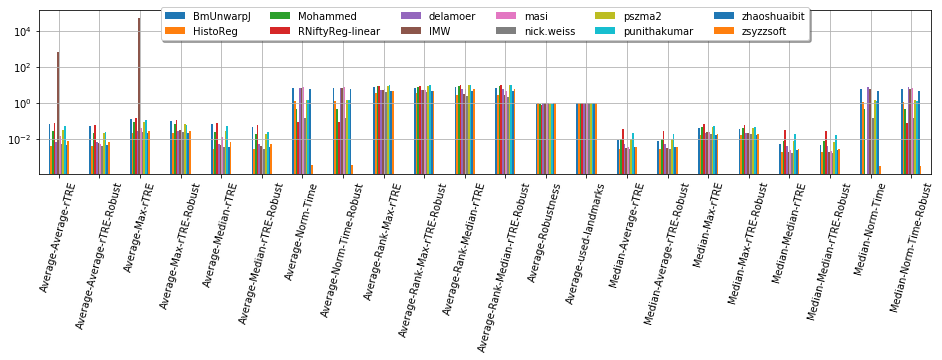

In [11]:
ax = pd.DataFrame(user_aggreg).T[cols_general].T.plot.bar(figsize=(16, 3), grid=True, logy=True, rot=75)
_= ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=int(len(users) / 2), fancybox=True, shadow=True)

## Compare statistic "train" vs "test"

Compute sts. on training and testing case also foor newly add rank measures.

In [12]:
for state in [VAL_STATUS_TRAIN, VAL_STATUS_TEST]:
    for field, field_agg in [# ('rTRE-Median', 'Average-Median-rTRE'),
                             ('rTRE-Median_rank', 'Average-Rank-Median-rTRE'),
                             # ('rTRE-Max', 'Average-Max-rTRE'),
                             ('rTRE-Max_rank', 'Average-Rank-Max-rTRE')]:
        for user in users:
            # chose inly robyst if it is required
            vals = [user_cases[user][cs][field] for cs in user_cases[user]
                    if user_cases[user][cs]['Status'] == state]
            user_aggreg[user][field_agg + '_' + state] = np.nanmean(vals)

Display just raw table with results.

In [13]:
df = pd.DataFrame(user_aggreg).T
cols = [col for col in df.columns if any(st in col for st in [VAL_STATUS_TRAIN, VAL_STATUS_TEST])]
df[cols].sort_values('Average-Rank-Median-rTRE_evaluation')

,Average-Average-rTRE_evaluation,Average-Average-rTRE_training,Average-Max-rTRE_evaluation,Average-Max-rTRE_training,Average-Median-rTRE_evaluation,Average-Median-rTRE_training,Average-Rank-Max-rTRE_evaluation,Average-Rank-Max-rTRE_training,Average-Rank-Median-rTRE_evaluation,Average-Rank-Median-rTRE_training,Average-Robustness_evaluation,Average-Robustness_training,Median-Average-rTRE_evaluation,Median-Average-rTRE_training,Median-Max-rTRE_evaluation,Median-Max-rTRE_training,Median-Median-rTRE_evaluation,Median-Median-rTRE_training
nick.weiss,0.004363,0.006096,0.025107,0.027120,0.002871,0.004924,4.430279,3.982609,2.342629,2.291304,1.000000,0.995652,0.002740,0.002964,0.018827,0.018286,0.001804,0.001857
HistoReg,0.004197,0.004016,0.023776,0.022330,0.002865,0.002805,3.713147,3.508696,2.912351,2.673913,1.000000,1.000000,0.002925,0.003054,0.019007,0.017197,0.001874,0.001970
lMW,0.011127,1416.683056,0.165048,108310.957339,0.005480,0.004639,5.294821,5.778261,3.015936,3.065217,0.984064,0.995652,0.003276,0.003781,0.023075,0.023733,0.001913,0.002166
masi,0.010566,0.018578,0.028788,0.037658,0.005212,0.004582,5.326693,6.569565,4.952191,6.443478,0.991667,0.994152,0.003176,0.005045,0.020622,0.027420,0.002092,0.003132
delamoer,0.005670,0.007972,0.025789,0.028570,0.004181,0.006717,5.155378,5.747826,5.354582,7.465217,1.000000,0.986957,0.004431,0.006027,0.019567,0.022732,0.003281,0.005048
zhaoshuaibit,0.005601,0.003750,0.025426,0.019960,0.004251,0.002693,4.844622,3.952174,5.737052,3.847826,0.996016,1.000000,0.003750,0.003421,0.020072,0.016432,0.002699,0.002447
zsyzzsoft,0.010763,0.005412,0.033000,0.024565,0.009398,0.004178,5.087649,4.486957,6.338645,5.991304,0.996016,1.000000,0.003755,0.004066,0.019629,0.019232,0.002900,0.003118
BmUnwarpJ,0.097243,0.036243,0.181189,0.085343,0.097053,0.034088,7.438247,7.560870,7.657371,7.386957,0.920319,0.939130,0.008032,0.010063,0.038716,0.045554,0.005398,0.005869
Mohammed,0.032730,0.027425,0.085982,0.085782,0.028643,0.023044,8.334661,8.221739,8.980080,8.704348,0.924303,0.908696,0.010296,0.011298,0.041996,0.047450,0.007907,0.008264
pszma2,0.036015,0.029512,0.093703,0.088900,0.031776,0.025166,9.334661,9.208696,9.948207,9.665217,0.908367,0.913043,0.010096,0.010820,0.041752,0.046148,0.007907,0.008228


Transform the case format data to be simple form with extra colums for used and case ID to be able to draw a violine plot later.

In [14]:
dfs_cases = []
for usr in users:
    df = pd.DataFrame(user_cases[usr]).T
    df['user'] = usr
    df['case'] = df.index
    dfs_cases.append(df)
df_cases = pd.concat(dfs_cases).reset_index()

for col in df_cases.columns:
    try: df_cases[col] = pd.to_numeric(df_cases[col])
    except Exception: pass
# df_cases.head()

Showing several violine plots depending on what is the target variable.

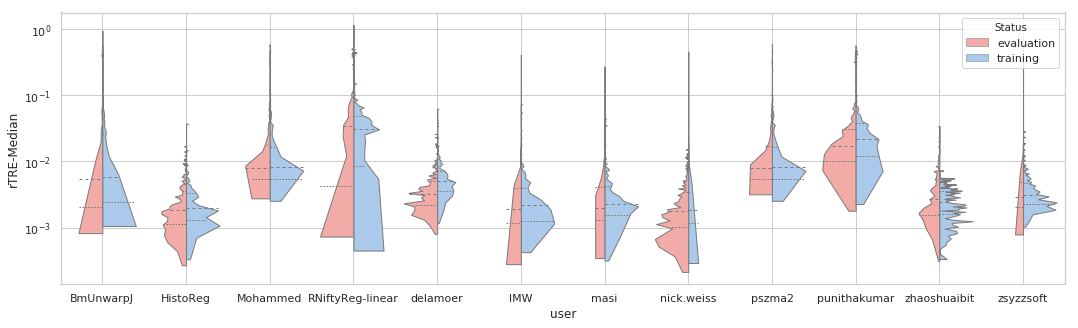

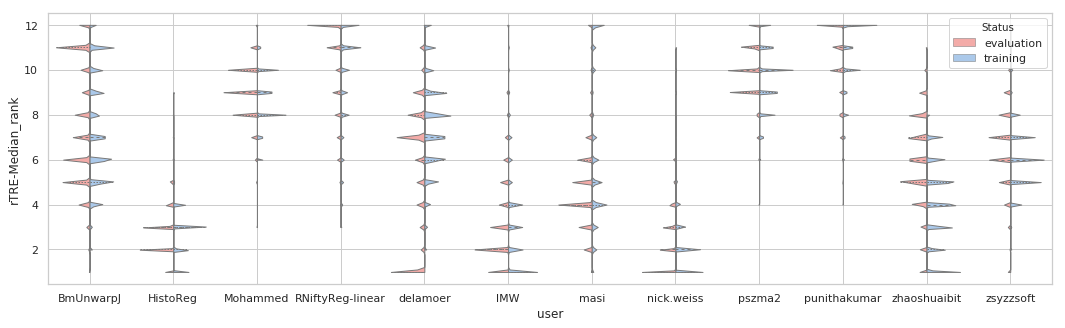

In [15]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)
for field, log in [('rTRE-Median', True), ('rTRE-Median_rank', False)]:
    fig, ax = plt.subplots(figsize=(18, 5))
    sns.violinplot(ax=ax, data=df_cases, x='user', hue='Status', y=field,
                   cut=0, split=True, bw=0.02, scale='area', scale_hue=True, inner='quartile',
                   palette={"evaluation": "r", "training": "b"}, linewidth=1., rot=60)
    if log:
        ax.set_yscale('log')
    ax.grid(True)

## Visualise global results

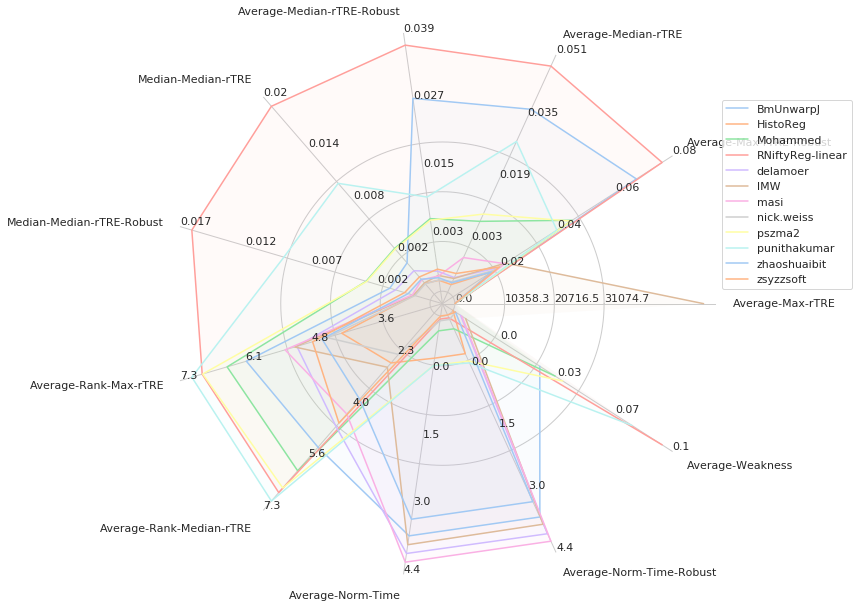

In [16]:
fields = ['Average-Max-rTRE', 'Average-Max-rTRE-Robust',
          'Average-Median-rTRE', 'Average-Median-rTRE-Robust',
          'Median-Median-rTRE', 'Median-Median-rTRE-Robust',
          'Average-Rank-Max-rTRE', 'Average-Rank-Median-rTRE',
          'Average-Norm-Time', 'Average-Norm-Time-Robust',
          'Average-Robustness',]
df = pd.DataFrame(user_aggreg).T[fields]
df['Average-Weakness'] = 1 - df['Average-Robustness']
del df['Average-Robustness']

radar = RadarChart(df, fig=plt.figure(figsize=(12, 8)))

## Visualise partial results

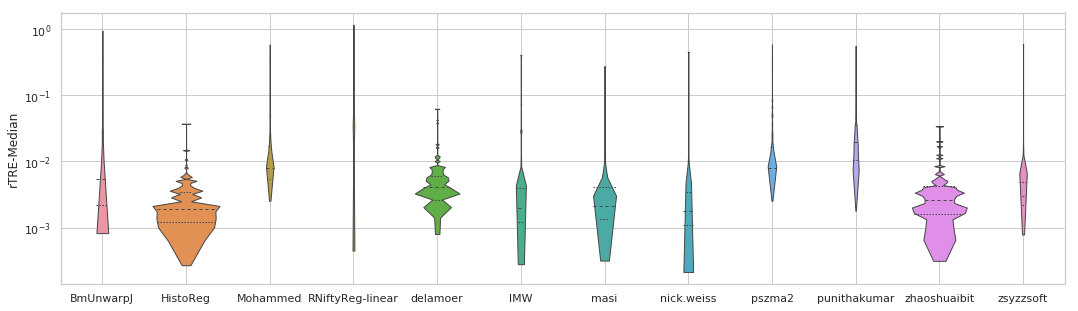

In [18]:
# from plotly.offline import init_notebook_mode, plot, iplot
# import plotly.figure_factory as ff
# init_notebook_mode(connected=True)

for field in ['rTRE-Median']:  # , 'rTRE-Max'
    df = pd.DataFrame({us: {cs: user_cases[us][cs][field] for cs in user_cases[us]} for us in users})
    # fig = ff.create_distplot([df[us].values for us in users], users, bin_size=0.001)
    # iplot(fig, logx=True)
    fig, ax = plt.subplots(figsize=(18, 5))
    sns.violinplot(ax=ax, data=df, split=True, cut=0, bw=.005, scale='area', inner='quartile', linewidth=1.)
    _ = ax.set_yscale('log'), ax.set_ylabel(field)
    ax.grid(True)
